In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

import jieba

In [2]:
# 读取Excel文件
file_path = './dataset_excel/datasets_english_and_tag.xlsx'  # 请替换为实际的文件路径
data = pd.read_excel(file_path)

data['text'] = data['text_translated']
del data['text_translated']
data.head()

,Unnamed: 0,text,Authority Bias,Survivorship Bias,Pessimism Bias,Zero-Risk Bias,Hyperbolic Discounting,Identifiable Victim Effect,Appeal to Novelty,Urgency Effect,Curiosity,Conformity
0,0,"1. Cheer up, your little dimensional troubles ...",0,0,1,0,0,0,0,0,1,0
1,1,6. We have counterfeit Swiss men's and women's...,0,0,0,0,0,0,0,0,1,1
2,2,9. Don't consolidate your debt Eliminate it!...,0,0,1,0,0,0,0,0,1,0
3,3,10. Adobe Creative Suite 3 Master Collection f...,1,0,0,0,0,0,0,0,1,0
4,4,13. Expresssherbals http://pacelike.com In the...,0,0,0,0,0,0,0,0,1,0


In [15]:
import os
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import jieba
import pandas as pd
import numpy as np
import joblib

# 设置随机数种子以保证实验可复现
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 创建保存模型的目录
model_dir = './model_pth'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# 文本预处理：分词（中文分词 + 英文以空格分词）
def preprocess_text(text):
    words = jieba.lcut(text)  # 使用jieba进行中文分词
    return ' '.join(words)

# 定义评估模型的函数
def evaluate_model(data, model, model_name):
    # 第二列为文本数据
    texts = data.iloc[:, 1].astype(str)  # 转换为字符串

    # 对所有文本进行预处理
    texts = texts.apply(preprocess_text)

    # 使用TF-IDF将文本转换为特征向量
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(texts)
    joblib.dump(vectorizer, './model_pth/tfidf_vectorizer.joblib')
    # 有监督学习
    labels = data.iloc[:, 2:]  # 真实标签

    results = {}
    for column in labels.columns:
        y = labels[column].values

        # 使用SMOTE进行过采样
        smote = SMOTE(random_state=RANDOM_SEED)
        X_resampled, y_resampled = smote.fit_resample(X, y)

        # 重新划分训练集和测试集
        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=RANDOM_SEED)

        # 使用传入的模型进行训练和评估
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # 保存模型
        model_filename = os.path.join(model_dir, f'{model_name}_{column}.joblib')
        joblib.dump(model, model_filename)

        accuracy = accuracy_score(y_test, y_pred)
        results[column] = f"{accuracy * 100:.2f}%"  # 转换为百分比并保留两位小数

    average_accuracy = sum(float(acc[:-1]) for acc in results.values()) / len(results)  # 计算平均准确率
    return results, f"{average_accuracy:.2f}%"  # 保留两位小数

# 存储不同模型的结果
model_results = []

# 定义要测试的模型
models = {
    'SVM': SVC(kernel='linear', probability=True, random_state=RANDOM_SEED),
}

# 评估每个模型并存储结果
for model_name, model in models.items():
    accuracies, avg_accuracy = evaluate_model(data, model, model_name)
    model_results.append({
        'Model': model_name,
        **accuracies,  # 展开每个标签的准确率
        'Average Accuracy': avg_accuracy
    })

# 创建结果的DataFrame
df_results = pd.DataFrame(model_results)

# 显示结果
df_results

,Model,Authority Bias,Survivorship Bias,Pessimism Bias,Zero-Risk Bias,Hyperbolic Discounting,Identifiable Victim Effect,Appeal to Novelty,Urgency Effect,Curiosity,Conformity,Average Accuracy
0,SVM,83.64%,99.61%,85.88%,85.37%,89.44%,100.00%,97.44%,79.76%,87.13%,95.44%,90.37%


### 对于钓鱼邮件数据集使用预训练模型对认知偏差进行检测

In [30]:
df = pd.read_csv('/data/yyl/model/cls/phishing/dataset_raw/CEAS-08.csv')

# 统计label标签中1和0的数量
df.head()

,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1


In [31]:
import os
import joblib
import jieba
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

def load_models(model_dir):
    """加载指定目录中的所有模型，模型名格式为 SVM_{model_name}.joblib"""
    models = {}
    for filename in os.listdir(model_dir):
        if filename.endswith('.joblib') and filename.startswith('SVM_'):
            model_name = filename.replace('SVM_', '').replace('.joblib', '')
            model_path = os.path.join(model_dir, filename)
            models[model_name] = joblib.load(model_path)
    print(f'Total models loaded: {len(models)}')
    return models

def preprocess_text(text):
    """文本预处理函数：分词（中文分词 + 英文以空格分词）"""
    words = jieba.lcut(text)
    return ' '.join(words)

def predict_with_models(data, text_column, models, vectorizer):
    """使用所有模型对数据进行预测，并将结果添加到DataFrame中"""
    texts = data[text_column].astype(str)
    texts = texts.apply(preprocess_text)
    
    # 将文本数据转换为TF-IDF特征向量
    X = vectorizer.transform(texts)
    print(f'TF-IDF feature shape: {X.shape}')
    
    for model_name, model in models.items():
        predictions = model.predict(X)
        data[model_name] = predictions
    
    return data

def evaluate_csv_with_models(csv_path, model_dir, text_column='text', output_csv_path=None):
    """加载CSV文件，对其中的文本数据使用所有模型进行预测，并保存结果"""
    data = pd.read_csv(csv_path)
    models = load_models(model_dir)
    
    # 加载之前保存的TF-IDF向量器
    vectorizer = joblib.load(os.path.join(model_dir, 'tfidf_vectorizer.joblib'))
    
    # 对每行文本使用所有模型进行预测
    predictions_df = predict_with_models(data, text_column, models, vectorizer)
    
    # 保留 'label' 列、文本列（重命名为 'text'）、以及所有预测结果列，删除其他列
    columns_to_keep = ['label', text_column] + list(models.keys())
    predictions_df = predictions_df[columns_to_keep]
    predictions_df.rename(columns={text_column: 'text'}, inplace=True)
    
    # 如果指定了输出路径，则将结果保存为新的CSV文件
    if output_csv_path:
        if not os.path.exists('./dataset_more'):
            os.makedirs('./dataset_more')
        output_csv_path = os.path.join('./dataset_more', output_csv_path)
        predictions_df.to_csv(output_csv_path, index=False)
    
    return predictions_df

# 使用示例
csv_path = '/data/yyl/model/cls/phishing/dataset_raw/CEAS-08.csv'
model_dir = './model_pth'
text_column = 'body'  # 假设原始文件中的文本列名
output_csv_name = 'CEAS-08_bias.csv'

# 运行模型预测并保存结果
predictions_df = evaluate_csv_with_models(csv_path, model_dir, text_column, output_csv_name)

Total models loaded: 10
TF-IDF feature shape: (39154, 7932)


/tmp/ipykernel_3889103/1479127392.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions_df.rename(columns={text_column: 'text'}, inplace=True)


In [3]:
df = pd.read_csv('/data/yyl/model/cls/phishing/dataset_more/Nigerian_5_bias.csv')
df.head()

,label,text,Urgency Effect,Zero-Risk Bias,Identifiable Victim Effect,Survivorship Bias,Conformity,Hyperbolic Discounting,Curiosity,Authority Bias,Appeal to Novelty,Pessimism Bias
0,0,User ID: enrondlr PW: bnaweb22 -----O...,1,0,0,0,1,1,1,1,0,0
1,0,"\nHi Chris, \n\nTonight we are rolling out a ...",0,0,0,0,1,1,0,0,0,0
2,0,Rika r these new?\n\n -----Original Message---...,0,0,0,0,1,1,1,0,0,0
3,0,"John/Gerald, We are currently trading under GT...",1,0,0,0,1,1,1,1,0,0
4,0,Gerald and Stacy -\n\nAttached is a worksheet ...,1,0,0,0,1,0,1,1,0,0


### 分析

In [2]:
df = pd.read_csv('/data/yyl/model/cls/phishing/dataset_more/Nigerian_5_bias.csv')

# 列出所有认知偏差列
bias_columns = [
    'Urgency Effect', 'Zero-Risk Bias',
    'Identifiable Victim Effect', 'Survivorship Bias',
    'Conformity', 'Hyperbolic Discounting',
    'Curiosity', 'Authority Bias',
    'Appeal to Novelty', 'Negativity Bias'
]

# 按标签分组计算每种认知偏差的平均值
bias_means = df.groupby('label')[bias_columns].mean().T
bias_means.columns = ['Non-Phishing', 'Phishing']

# 显示结果
bias_means

,Non-Phishing,Phishing
Urgency Effect,0.177726,0.926771
Zero-Risk Bias,0.179727,0.907863
Identifiable Victim Effect,0.030677,0.926170
Survivorship Bias,0.025342,0.951080
Conformity,0.836612,0.980192
Hyperbolic Discounting,0.600867,0.979892
Curiosity,0.757919,0.035114
Authority Bias,0.308436,0.964586
Appeal to Novelty,0.102034,0.005402
Negativity Bias,0.097032,0.872749


/tmp/ipykernel_1941058/1353408914.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


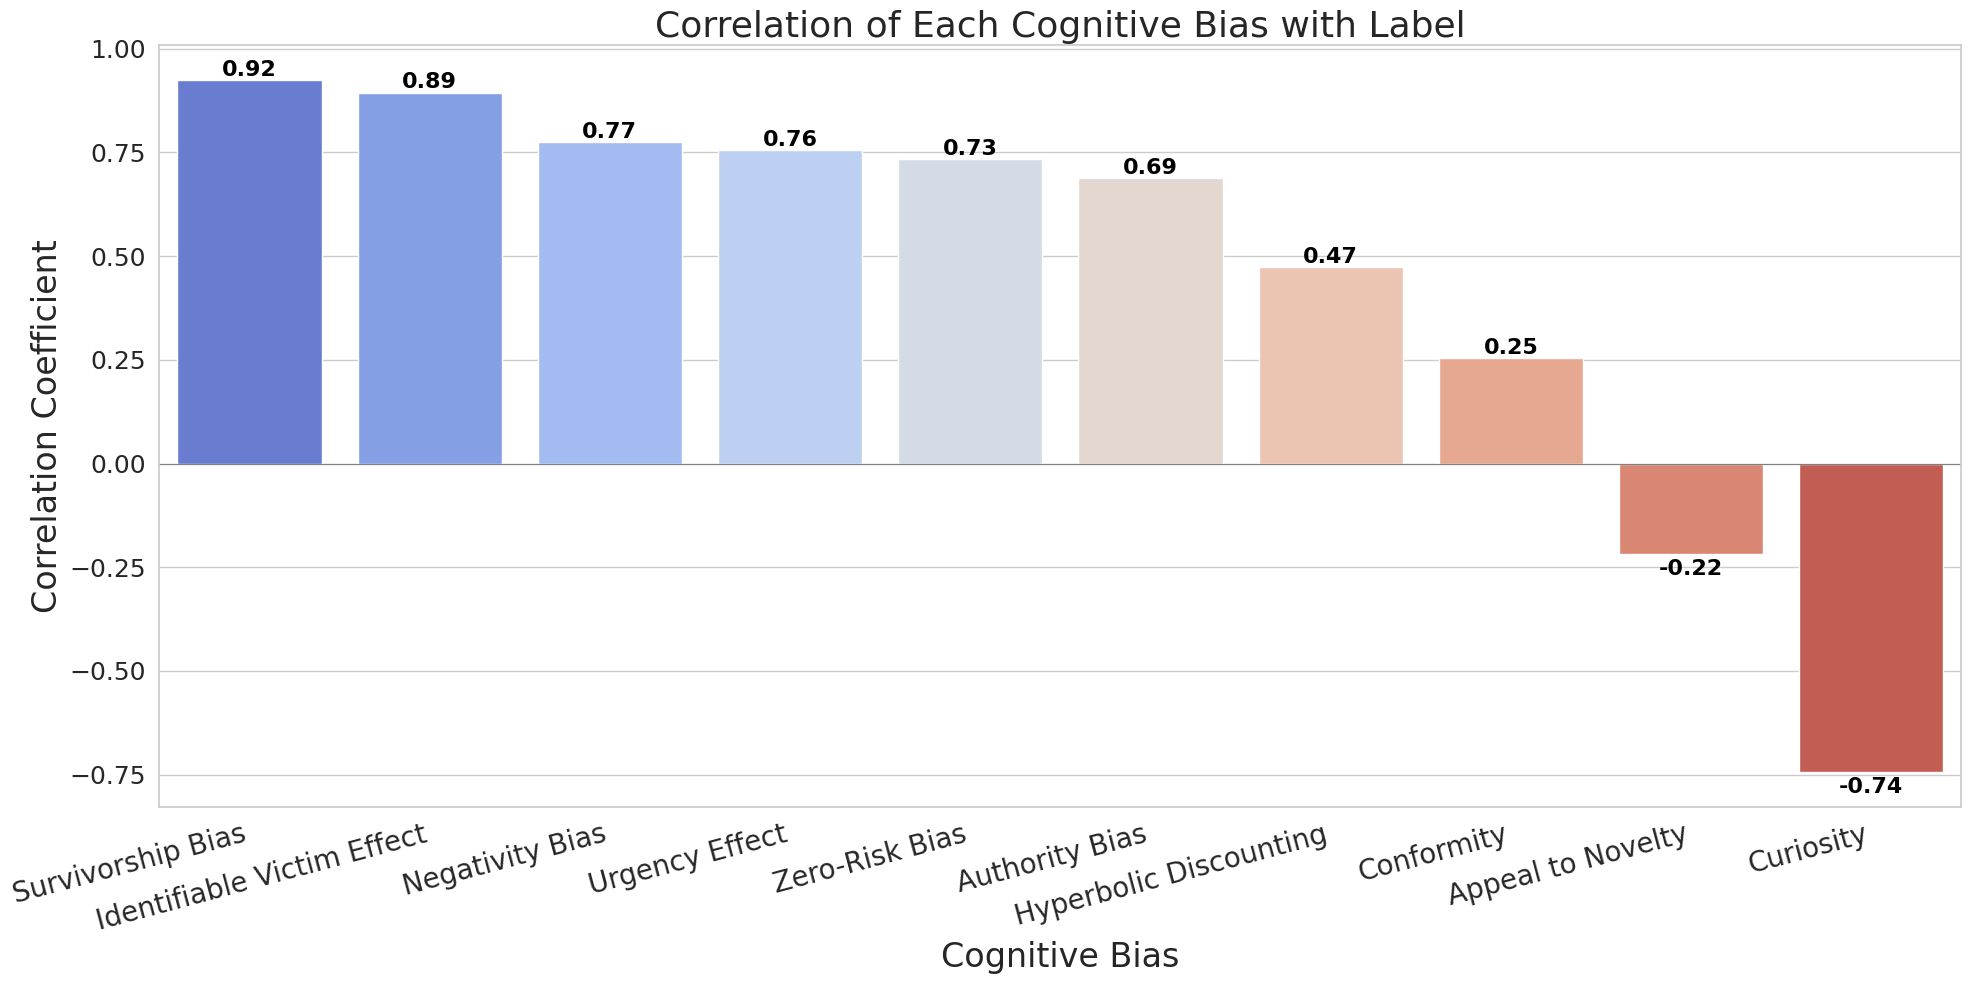

In [3]:
# 选择相关列并计算相关性
data = df[bias_columns + ['label']].dropna()
correlations = data.corr()['label'].drop('label')

# 按相关系数降序排序
correlations_sorted = correlations.sort_values(ascending=False)

# 设置绘图风格
sns.set(style='whitegrid')

# 设置绘图尺寸
plt.figure(figsize=(20, 10))

# 绘制排序后的柱状图，使用 'coolwarm' 调色板更好地反映相关性方向
ax = sns.barplot(
    x=correlations_sorted.index, 
    y=correlations_sorted.values, 
    palette='coolwarm', 
    dodge=False
)

# 添加基准线（y=0）以区分正负相关
plt.axhline(0, color='grey', linewidth=0.8)

# 添加数值标签，调整字体大小
for i, v in enumerate(correlations_sorted.values):
    if v >= 0:
        ax.text(i, v + 0.01, f"{v:.2f}", ha='center', color='black', fontweight='bold', fontsize=16)
    else:
        ax.text(i, v - 0.05, f"{v:.2f}", ha='center', color='black', fontweight='bold', fontsize=16)

# 添加标题和标签（已翻译），并增大字体大小
plt.title('Correlation of Each Cognitive Bias with Label', fontsize=26)
plt.ylabel('Correlation Coefficient', fontsize=24)
plt.xlabel('Cognitive Bias', fontsize=24)

# 调整x轴标签角度并增大字体大小
plt.xticks(rotation=15, ha='right', fontsize=20)

# 调整y轴刻度字体大小
plt.yticks(fontsize=18)

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()

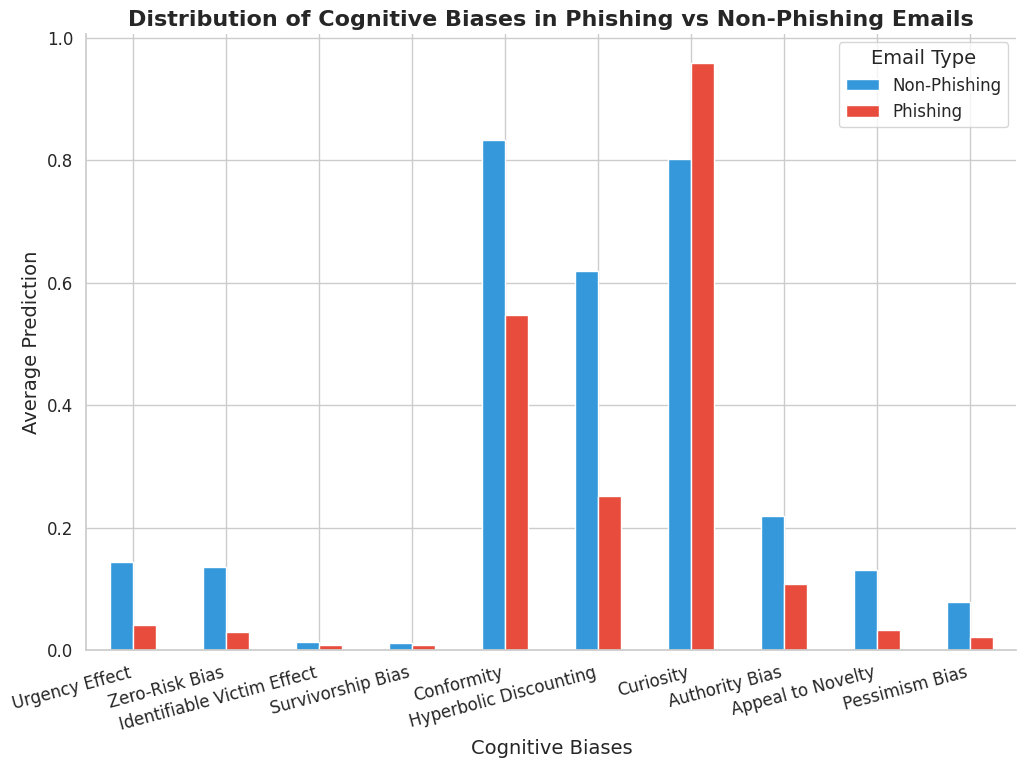

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置美化的风格
sns.set(style="whitegrid")

# 定义颜色
colors = ["#3498db", "#e74c3c"]  # 蓝色和红色

# 创建图表
fig, ax = plt.subplots(figsize=(12, 8))

# 绘制条形图
bias_means.plot(kind='bar', color=colors, ax=ax)

# 美化标题和标签
plt.title('Distribution of Cognitive Biases in Phishing vs Non-Phishing Emails', fontsize=16, weight='bold')
plt.xlabel('Cognitive Biases', fontsize=14)
plt.ylabel('Average Prediction', fontsize=14)

# 美化x轴标签
plt.xticks(rotation=15, ha='right', fontsize=12)

# 美化y轴标签
plt.yticks(fontsize=12)

# 美化图例
plt.legend(title='Email Type', title_fontsize=14, fontsize=12, loc='upper right')

# 去掉顶部和右侧边框
sns.despine()

# 显示图表
plt.show()

### 偏差对钓鱼邮件检测建模测试

In [5]:
df = pd.read_csv('/data/yyl/model/cls/phishing/dataset_raw/Nigerian_5.csv')
df

,sender,receiver,date,subject,body,label,urls
0,"""Hu, Sylvia"" <Sylvia.Hu@ENRON.com>","""Acevedo, Felecia"" <Felecia.Acevedo@ENRON.com>...","Fri, 29 Jun 2001 08:36:09 -0500","FW: June 29 -- BNA, Inc. Daily Labor Report",User ID: enrondlr PW: bnaweb22 -----O...,0,1
1,"""Webb, Jay"" <Jay.Webb@ENRON.com>","""Lambie, Chris"" <Chris.Lambie@ENRON.com>","Fri, 29 Jun 2001 09:37:04 -0500",NGX failover plan.,"\nHi Chris, \n\nTonight we are rolling out a ...",0,0
2,"""Symms, Mark"" <Mark.Symms@ENRON.com>","""Thomas, Paul D."" <Paul.D.Thomas@ENRON.com>","Fri, 29 Jun 2001 08:39:30 -0500",RE: Intranet Site,Rika r these new?\n\n -----Original Message---...,0,1
3,"""Thorne, Judy"" <Judy.Thorne@ENRON.com>","""Grass, John"" <John.Grass@ENRON.com>, ""Nemec, ...","Fri, 29 Jun 2001 10:35:17 -0500",FW: ENA Upstream Company information,"John/Gerald, We are currently trading under GT...",0,0
4,"""Williams, Jason R (Credit)"" <Jason.R.Williams...","""Nemec, Gerald"" <Gerald.Nemec@ENRON.com>, ""Dic...","Fri, 29 Jun 2001 10:40:02 -0500",New Master Physical,Gerald and Stacy -\n\nAttached is a worksheet ...,0,0
...,...,...,...,...,...,...,...
6326,harley@argote.ch (Robert Harley),fork@spamassassin.taint.org,"Tue, 17 Sep 2002 19:26:27 +0200 (CEST)",Re: Hanson's Sept 11 message in the National R...,Chuck Murcko wrote:\n> > The usual crud. Why ...,0,0
6327,Luis Villa <louie@ximian.com>,fork@spamassassin.taint.org,17 Sep 2002 13:36:49 -0400,Re: Slaughter in the Name of God,"On Tue, 2002-09-17 at 12:50, Justin Mason wrot...",0,0
6328,<michael@i-magery.com>,<fork@spamassassin.taint.org>,"Tue, 17 Sep 2002 13:41:50 -0400",FW: Wanna buy a nuke?,I have been told to take anything read in Prav...,0,1
6329,"""Owen Byrne"" <owen@permafrost.net>",Chuck Murcko <chuck@topsail.org>,"Tue, 17 Sep 2002 14:38:52 -0300",Re: Hanson's Sept 11 message in the National R...,"On Tue, Sep 17, 2002 at 10:19:13AM -0700, Chuc...",0,1


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import time

# 假设你的数据已加载到 df
df = pd.read_csv('/data/yyl/model/cls/phishing/dataset_more/Nigerian_5_bias.csv')
df = df.dropna()

# 定义模型
models = {
    'LogisticRegression': LogisticRegression(C=0.1, random_state=42),
    'MultinomialNB': MultinomialNB(),
    'SVM': SVC(kernel='linear', probability=True, C=0.1, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=20, random_state=42),
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

# 提取文本和标签
X = df['text']
y = df['label']

# 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 使用TF-IDF将文本转换为特征向量
vectorizer = TfidfVectorizer()
# vectorizer = CountVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# 存储每个模型的准确率
results = []

# 对每个模型进行训练和测试
for model_name, model in models.items():
    start_time = time.time()  # 记录开始时间
    
    model.fit(X_train_tfidf, y_train)  # 训练模型
    y_pred = model.predict(X_test_tfidf)  # 进行预测
    y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1] if hasattr(model, "predict_proba") else None  # 预测概率
    
    end_time = time.time()  # 记录结束时间
    elapsed_time = end_time - start_time  # 计算运行时间
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 'N/A'
    
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC-ROC': auc_roc,
        'Time (seconds)': elapsed_time
    })

# 将结果转换为DataFrame
results_df = pd.DataFrame(results)

# 显示结果
results_df

,Model,Accuracy,Precision,Recall,F1 Score,AUC-ROC,Time (seconds)
0,LogisticRegression,0.977368,0.994726,0.961264,0.977709,0.992737,0.943016


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import time

# 假设你的数据已加载到 df
df = pd.read_csv('/data/yyl/model/cls/phishing/dataset_more/Nigerian_5_bias.csv')
df = df.dropna()

# 定义模型
models = {
    'LogisticRegression': LogisticRegression(random_state=42),
    # 'MultinomialNB': MultinomialNB(),
    'SVM': SVC(kernel='linear', probability=True, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=1000, random_state=42),
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

# 提取文本、偏差特征和标签
bias_columns = [
    'Urgency Effect', 
    'Zero-Risk Bias',
    'Identifiable Victim Effect', 
    'Survivorship Bias',
    # 'Conformity', 
    # 'Hyperbolic Discounting',
    'Curiosity', 
    # 'Authority Bias',
    # 'Appeal to Novelty', 
    'Negativity Bias'
]

X = df[['text'] + bias_columns]
y = df['label']

# 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 使用TF-IDF将文本转换为特征向量
vectorizer = TfidfVectorizer()
# vectorizer = CountVectorizer()
X_train_text_tfidf = vectorizer.fit_transform(X_train['text'])
X_test_text_tfidf = vectorizer.transform(X_test['text'])

# 合并偏差特征和文本特征
import scipy.sparse as sp

X_train_tfidf = sp.hstack([X_train_text_tfidf, X_train[bias_columns].values])
X_test_tfidf = sp.hstack([X_test_text_tfidf, X_test[bias_columns].values])

# 存储每个模型的准确率
results = []

# 对每个模型进行训练和测试
for model_name, model in models.items():
    start_time = time.time()  # 记录开始时间
    
    model.fit(X_train_tfidf, y_train)  # 训练模型
    y_pred = model.predict(X_test_tfidf)  # 进行预测
    y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1] if hasattr(model, "predict_proba") else None  # 预测概率
    
    end_time = time.time()  # 记录结束时间
    elapsed_time = end_time - start_time  # 计算运行时间
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 'N/A'
    
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC-ROC': auc_roc,
        'Time (seconds)': elapsed_time
    })

# 将结果转换为DataFrame
results_df = pd.DataFrame(results)

# 显示结果
results_df

,Model,Accuracy,Precision,Recall,F1 Score,AUC-ROC,Time (seconds)
0,LogisticRegression,0.974211,0.979424,0.970438,0.974910,0.998542,1.749016
1,SVM,0.994211,0.997947,0.990826,0.994373,0.999758,29.306879
2,RandomForest,0.990000,0.998963,0.981651,0.990231,0.998809,29.662891
3,KNN,0.978421,0.976673,0.981651,0.979156,0.993964,2.131101
4,DecisionTree,0.975789,0.974619,0.978593,0.976602,0.975695,1.605537
5,GradientBoosting,0.986316,0.993795,0.979613,0.986653,0.998380,36.635142


### 不使用text只用bias

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import time

# 假设你的数据已加载到 df
df = pd.read_csv('/data/yyl/model/cls/phishing/dataset_more/Nigerian_5_bias.csv')

# 定义模型
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(kernel='linear', probability=True, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=20, random_state=42),
    'KNN': KNeighborsClassifier(),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

# 提取偏差特征和标签
bias_columns = [
    'Urgency Effect', 'Zero-Risk Bias',
    'Identifiable Victim Effect', 'Survivorship Bias',
    'Conformity', 'Hyperbolic Discounting',
    'Curiosity', 'Authority Bias',
    'Appeal to Novelty', 'Pessimism Bias'
]

X = df[bias_columns]
y = df['label']

# 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 存储每个模型的评估指标
results = []

# 对每个模型进行训练和测试
for model_name, model in models.items():
    start_time = time.time()  # 记录开始时间
    
    model.fit(X_train, y_train)  # 训练模型
    y_pred = model.predict(X_test)  # 进行预测
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None  # 预测概率
    
    end_time = time.time()  # 记录结束时间
    elapsed_time = end_time - start_time  # 计算运行时间
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 'N/A'
    
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC-ROC': auc_roc,
        'Time (seconds)': elapsed_time
    })

# 将结果转换为DataFrame
results_df = pd.DataFrame(results)

# 显示结果
results_df


,Model,Accuracy,Precision,Recall,F1 Score,AUC-ROC,Time (seconds)
0,LogisticRegression,0.960000,0.974816,0.946993,0.960703,0.981303,0.012303
1,SVM,0.963684,0.986141,0.942915,0.964044,0.967360,0.223346
2,RandomForest,0.962632,0.979958,0.946993,0.963193,0.981885,0.047295
3,KNN,0.955263,0.963768,0.949032,0.956343,0.976403,0.192643
4,DecisionTree,0.962105,0.981972,0.943935,0.962578,0.980656,0.005068
5,GradientBoosting,0.964737,0.984110,0.946993,0.965195,0.984309,0.207713
